In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as onp
from skimage import measure

import invrs_opt

from invrs_gym import challenges

I0000 00:00:1698262610.643606       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
# Select the challenge to be solved.
challenge = challenges.ceviche_lightweight_beam_splitter()

# Define the loss function; in this case we simply use the default challenge
# loss. Note that the loss function can return auxilliary quantities.
def loss_fn(params):
    response, aux = challenge.component.response(params)
    loss = challenge.loss(response)
    metrics = challenge.metrics(response, params, aux)
    return loss, (response, aux, metrics)

# Get the initial parameters, and initialize the optimizer.
params = challenge.component.init(jax.random.PRNGKey(0))
opt = invrs_opt.density_lbfgsb(beta=4)
state = opt.init(params)

# Carry out optimization for a fixed number of steps.
loss_values = []
metrics_values = []
for i in range(25):
    t0 = time.time()
    params = opt.params(state)
    (value, (response, aux, metrics)), grad = jax.value_and_grad(
        loss_fn, has_aux=True
    )(params)
    t1 = time.time()
    state = opt.update(grad=grad, value=value, params=params, state=state)
    
    print(f"{i:03} ({t1 - t0:.2f}/{time.time() - t1:.2f}s): loss={value:.3f}")
    loss_values.append(value)
    metrics_values.append(metrics)

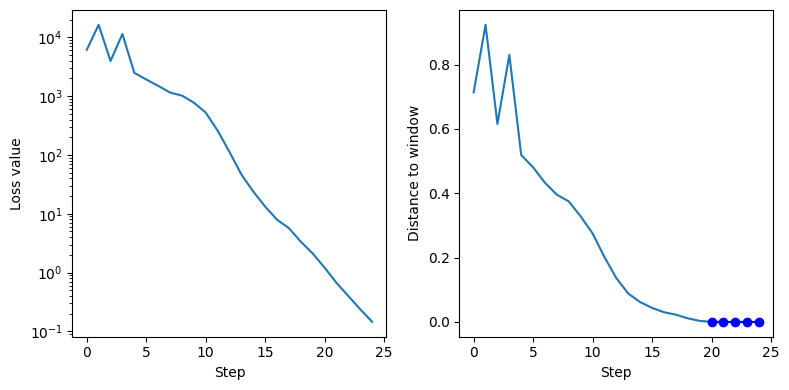

In [3]:
# Plot the loss vs. step, and the `distance_to_window`. The "window" is a
# region in the component response space; when the response is inside this
# region, the distance is zero and the challenge is considered solved.
step = onp.arange(len(loss_values))
distance_to_window = onp.asarray([m["distance_to_window"] for m in metrics_values])
mask = distance_to_window == 0

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.semilogy(step, loss_values)
plt.xlabel("Step")
plt.ylabel("Loss value")
plt.subplot(122)
plt.plot(step, distance_to_window)
plt.plot(step[mask], distance_to_window[mask], 'bo-')
plt.xlabel("Step")
plt.ylabel("Distance to window")

plt.tight_layout()

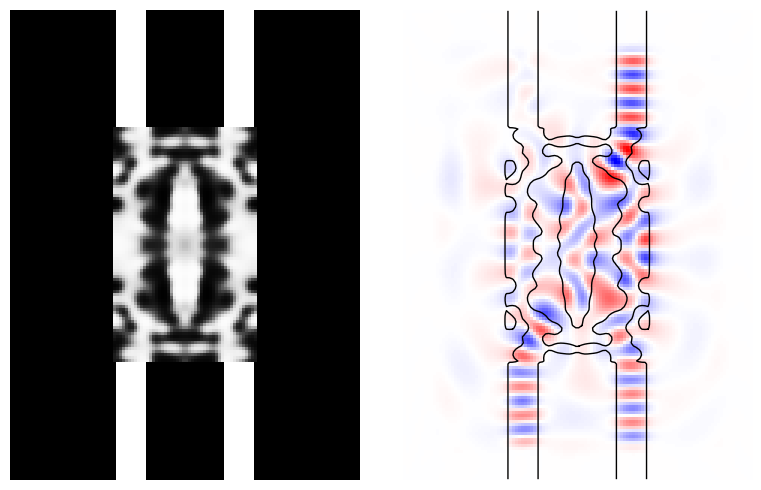

In [5]:
plt.figure(figsize=(8, 5))

# Plot fields, using some of the methods specific to the underlying ceviche model.
density = challenge.component.ceviche_model.density(params.array)

ax = plt.subplot(121)
ax.imshow(density, cmap="gray")
ax.axis(False)

# Plot the field, which is a part of the `aux` returned with the challenge response.
# The field will be overlaid with contours of the binarized design.
field = onp.real(aux["fields"])
field = field[0, 0, :, :]  # First wavelength, first excitation port.
contours = measure.find_contours(density)

ax = plt.subplot(122)
im = ax.imshow(field, cmap="bwr")
im.set_clim([-onp.amax(field), onp.amax(field)])
for c in contours:
    plt.plot(c[:, 1], c[:, 0], "k", lw=1)
ax.axis(False)

plt.tight_layout()